# [E-11]StockPrediction

## 시계열 데이터 준비

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## 전처리 수행

In [5]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]   # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [6]:
# 로그 변환
ts_log = np.log(ts)

## 시계열 안정성 분석

In [13]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()   # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()   # 이동표준편차 시계열
    
    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [16]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드 호출
    dftest = adfuller(timeseries, autolag='AIC')
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test :')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

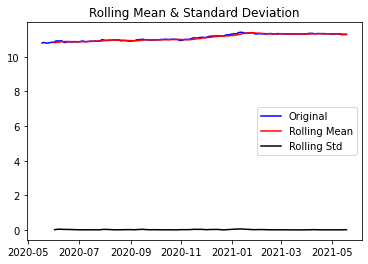

Results of Dickey-Fuller Test :
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


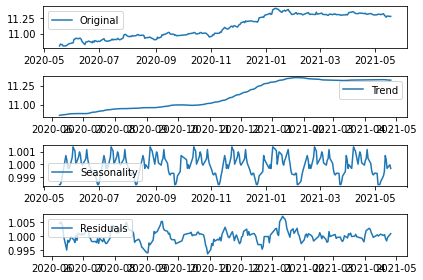

In [17]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dickey-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [18]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test :
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## 학습, 테스트 데이터셋 생성

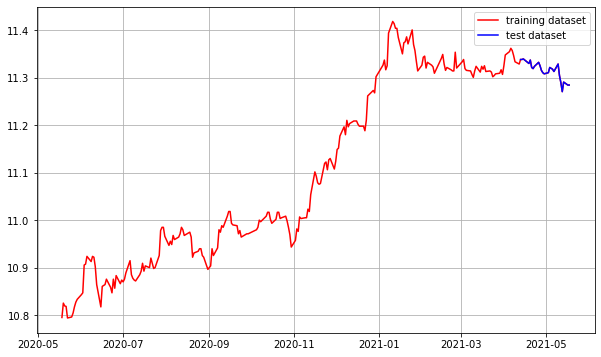

In [19]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 적정 ARIMA 모수 찾기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


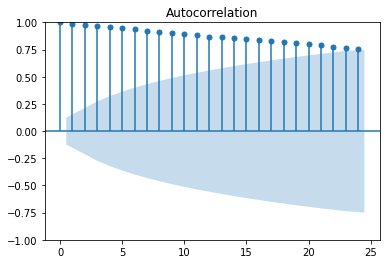

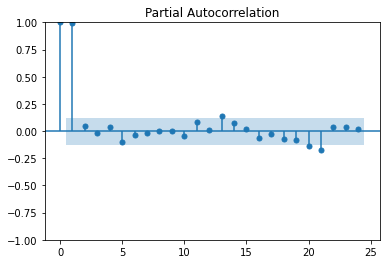

In [20]:
# ACF, PACF 그려보기 -> p, q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : AUTOCORRELATION 그래프 그리기
plot_pacf(ts_log)   # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test :
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test :
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


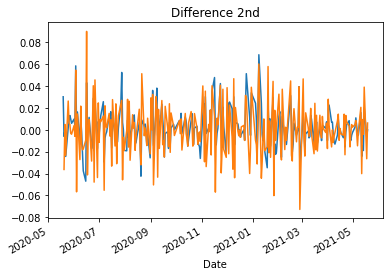

In [21]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## ARIMA 모델 빌드와 훈련

In [25]:
from statsmodels.tsa.arima.model import ARIMA

# Build Model
model = ARIMA(train_data, order=(2, 0, 1))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 17 Feb 2022   AIC                          -1156.722
Time:                        12:26:43   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


## 모델 테스트 및 플로팅

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


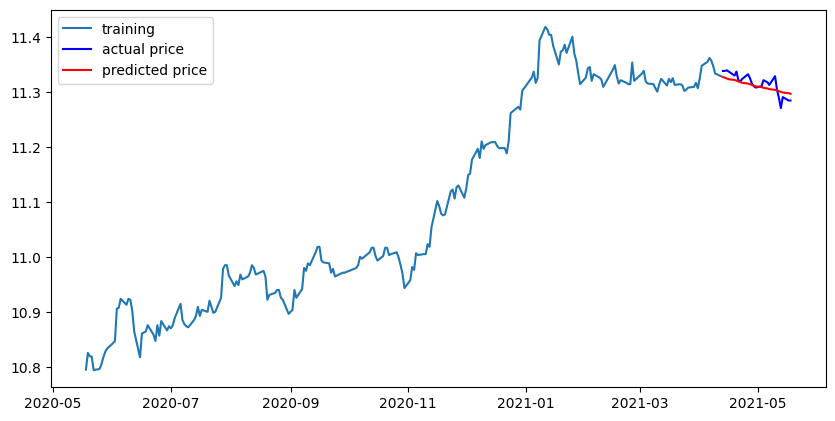

In [27]:
# Forecast : 결과가 fc에 담긴다
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

## 최종 예측 모델 정확도 측정(MAPE)

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE :', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE :', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE :', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE : {:.2f}%'.format(mape*100))

MSE : 1048973.6014239907
MAE : 843.7579531508708
RMSE : 1024.19412292006
MAPE : 1.03%


## 1. Apple

In [31]:
# 데이터 준비
dataset_filepath_appl = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
df_appl = pd.read_csv(dataset_filepath_appl, index_col='Date', parse_dates=True)
ts_appl = df_appl['Close']

ts_appl.head()

Date
2021-02-17    130.839996
2021-02-18    129.710007
2021-02-19    129.869995
2021-02-22    126.000000
2021-02-23    125.860001
Name: Close, dtype: float64

In [32]:
# 결측치 처리
ts_appl = ts_appl.interpolate(method='time')
ts_appl[ts_appl.isna()]   # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [33]:
# 로그 변환
ts_appl_log = np.log(ts_appl)

In [34]:
# 학습, 테스트 데이터셋 생성
train_data_appl, test_data_appl = ts_appl_log[:int(len(ts_appl_log)*0.9)], ts_appl_log[int(len(ts_appl_log)*0.9):]


In [36]:
# ARIMA 모델 빌드와 훈련

# Build Model
model_appl = ARIMA(train_data_appl, order=(2, 0, 1))
fitted_m_appl = model_appl.fit()

print(fitted_m_appl.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 629.132
Date:                Thu, 17 Feb 2022   AIC                          -1248.263
Time:                        12:54:30   BIC                          -1231.117
Sample:                             0   HQIC                         -1241.345
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9556      0.368     13.454      0.000       4.234       5.678
ar.L1          1.4366      0.666      2.157      0.031       0.131       2.742
ar.L2         -0.4378      0.664     -0.659      0.5

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


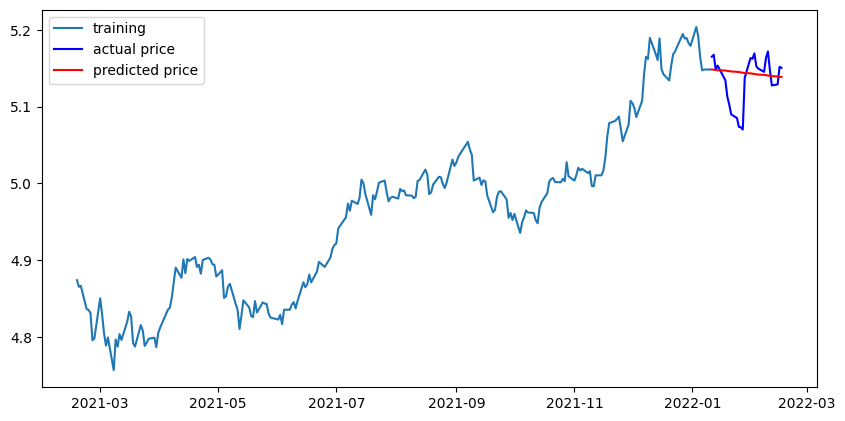

In [38]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담긴다
fc_appl = fitted_m_appl.forecast(len(test_data_appl), alpha=0.05)  # 95% conf
fc_appl = np.array(fc_appl)

# Make as pandas series
fc_series_appl = pd.Series(fc_appl, index=test_data_appl.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_appl, label='training')
plt.plot(test_data_appl, c='b', label='actual price')
plt.plot(fc_series_appl, c='r',label='predicted price')
plt.legend()
plt.show()

In [39]:
# 최종 예측 모델 정확도 측정
mse_appl = mean_squared_error(np.exp(test_data_appl), np.exp(fc_appl))
print('MSE :', mse_appl)

mae_appl = mean_absolute_error(np.exp(test_data_appl), np.exp(fc_appl))
print('MAE :', mae_appl)

rmse_appl = math.sqrt(mean_squared_error(np.exp(test_data_appl), np.exp(fc_appl)))
print('RMSE :', rmse_appl)

mape_appl = np.mean(np.abs(np.exp(fc_appl) - np.exp(test_data_appl))/np.abs(np.exp(test_data_appl)))
print('MAPE : {:.2f}%'.format(mape_appl*100))

MSE : 32.45152747631074
MAE : 4.344695480989407
RMSE : 5.696624217579279
MAPE : 2.62%


## 2. Netflix

In [58]:
# 데이터 준비
dataset_filepath_nflx = os.getenv('HOME') + '/aiffel/stock_prediction/data/NFLX.csv'
df_nflx = pd.read_csv(dataset_filepath_nflx, index_col='Date', parse_dates=True)
ts_nflx = df_nflx['Close']

In [59]:
# 결측치 처리
ts_nflx = ts_nflx.interpolate(method='time')
ts_nflx[ts_nflx.isna()]   # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [60]:
# 로그 변환
ts_log_nflx = np.log(ts_nflx)

In [61]:
# 학습, 테스트 데이터셋 생성
train_data_nflx, test_data_nflx = ts_log_nflx[:int(len(ts_log_nflx)*0.65)], ts_log_nflx[int(len(ts_log_nflx)*0.65):]


In [62]:
# ARIMA 모델 빌드와 훈련

# Build Model
model_nflx = ARIMA(train_data_nflx, order=(2, 0, 1))
fitted_m_nflx = model_nflx.fit()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


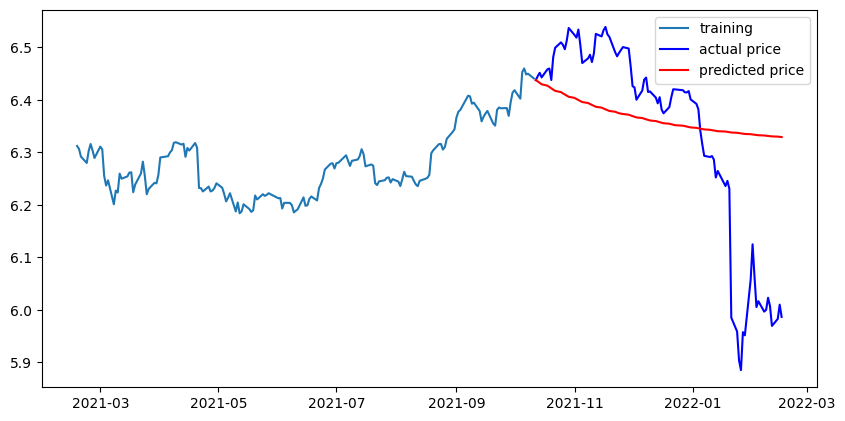

In [63]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담긴다
fc_nflx = fitted_m_nflx.forecast(len(test_data_nflx), alpha=0.05)  # 95% conf
fc_nflx = np.array(fc_nflx)

# Make as pandas series
fc_series_nflx = pd.Series(fc_nflx, index=test_data_nflx.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_nflx, label='training')
plt.plot(test_data_nflx, c='b', label='actual price')
plt.plot(fc_series_nflx, c='r',label='predicted price')
plt.legend()
plt.show()

In [64]:
# 최종 예측 모델 정확도 측정
mse_nflx = mean_squared_error(np.exp(test_data_nflx), np.exp(fc_nflx))
print('MSE :', mse_nflx)

mae_nflx = mean_absolute_error(np.exp(test_data_nflx), np.exp(fc_nflx))
print('MAE :', mae_nflx)

rmse_nflx = math.sqrt(mean_squared_error(np.exp(test_data_nflx), np.exp(fc_nflx)))
print('RMSE :', rmse_nflx)

mape_nflx = np.mean(np.abs(np.exp(fc_nflx) - np.exp(test_data_nflx))/np.abs(np.exp(test_data_nflx)))
print('MAPE : {:.2f}%'.format(mape_nflx*100))

MSE : 7793.383073913933
MAE : 70.20564644810716
RMSE : 88.28013974792934
MAPE : 14.31%


## 3. POSCO

In [66]:
# 데이터 준비
dataset_filepath_psc = os.getenv('HOME') + '/aiffel/stock_prediction/data/005490.KS.csv'
df_psc = pd.read_csv(dataset_filepath_psc, index_col='Date', parse_dates=True)
ts_psc = df_psc['Close']

In [67]:
# 결측치 처리
ts_psc = ts_psc.interpolate(method='time')
ts_psc[ts_psc.isna()]   # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [68]:
# 로그 변환
ts_log_psc = np.log(ts_psc)

In [69]:
# 학습, 테스트 데이터셋 생성
train_data_psc, test_data_psc = ts_log_psc[:int(len(ts_log_psc)*0.9)], ts_log_psc[int(len(ts_log_psc)*0.9):]


In [70]:
# ARIMA 모델 빌드와 훈련

# Build Model
model_psc = ARIMA(train_data_psc, order=(2, 0, 1))
fitted_m_psc = model_psc.fit()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


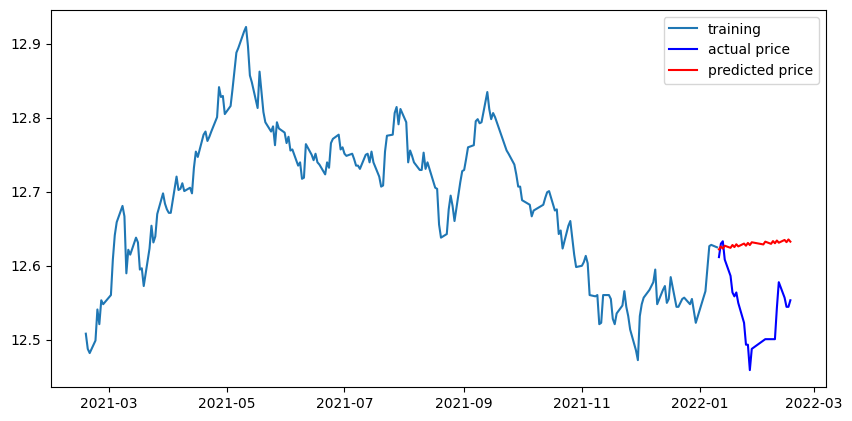

In [71]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담긴다
fc_psc = fitted_m_psc.forecast(len(test_data_psc), alpha=0.05)  # 95% conf
fc_psc = np.array(fc_psc)

# Make as pandas series
fc_series_psc = pd.Series(fc_psc, index=test_data_psc.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_psc, label='training')
plt.plot(test_data_psc, c='b', label='actual price')
plt.plot(fc_series_psc, c='r',label='predicted price')
plt.legend()
plt.show()

In [72]:
# 최종 예측 모델 정확도 측정
mse_psc = mean_squared_error(np.exp(test_data_psc), np.exp(fc_psc))
print('MSE :', mse_psc)

mae_psc = mean_absolute_error(np.exp(test_data_psc), np.exp(fc_psc))
print('MAE :', mae_psc)

rmse_psc = math.sqrt(mean_squared_error(np.exp(test_data_psc), np.exp(fc_psc)))
print('RMSE :', rmse_psc)

mape_psc = np.mean(np.abs(np.exp(fc_psc) - np.exp(test_data_psc))/np.abs(np.exp(test_data_psc)))
print('MAPE : {:.2f}%'.format(mape_psc*100))

MSE : 805023184.5455517
MAE : 25205.7515672524
RMSE : 28372.930489210165
MAPE : 9.22%


# 회고

이론적인 내용은 어려웠으나 모델 구성은 생각보다 간단했다.  
다른 종목들은 MAPE 값이 15% 미만으로 나왔지만, Netflix 의 경우 기존 설정했던 비율로 테스트 셋 & 트레인 셋을 구성하니 20% 이상 값이 나왔다.  
그래서 테스트 셋과 트레인 셋 비율을 조정하여 MAPE 15% 미만의 정확도로 예측할 수 있도록 만들었다.  